# Compare the LRG IR-selection sytematics between DES and DECaLS regions    
We do LASSO based training using a healpix map of `nside=128` but do the testing using a healpix map of `nside=32` to reduce variance.

Also we fit the model **only** to the DECaLS region but testing is done on **both** DES and DECaLS

In [1]:
import pandas as pd
import numpy as np
import healpy as hp

import matplotlib.pyplot as plt
import matplotlib.lines as lines

from astropy.table import Table as T
from astropy.coordinates import SkyCoord

from scipy.stats import binned_statistic, iqr

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, median_absolute_error

from helpFunc import plot_hpix

Load the data and select only `DECaLS`

In [2]:
hpTable = T.read("/home/bid13/code/desi/DESI-LASSO/data_new/heapix_map_lrg_ir_nominal_20191024_clean_combined_128.fits")
pix_area = hp.pixelfunc.nside2pixarea(128, degrees=True)

#Moving to pandas
data=hpTable.to_pandas()
data=data.dropna()
data=data.reset_index(drop=True)
data["region"] = data["region"].str.decode("utf-8")

In [3]:
#Select DECaLS for training
data = data[data.region=="decals"]

#put in galactic long and lat
coords = SkyCoord(ra = data.ra, dec =data.dec, unit = "deg")
data["cos(l)"] = coords.galactic.l.radian
data["cos(b)"] =coords.galactic.b.radian

data["cos(l)"] = np.cos(data["cos(l)"])
data["cos(b)"] = np.cos(data["cos(b)"])

#The regression is weighted using the fraction of area occupied in the pixel
data["weight"] = data["pix_frac"]/data["pix_frac"].max()

data["pix_area"] = pix_area*data["pix_frac"]
data["pix_pop"] = data["density"]*data["pix_area"]

#Columns to keep
columns = ['EBV', 'galdepth_gmag', 'galdepth_rmag', 'galdepth_zmag','psfdepth_w1mag', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'stardens_log',"cos(l)","cos(b)"]

#Scale the training data by subtracting the mean and dividing by std for each feature
scaler = StandardScaler()
scaled_data= scaler.fit_transform(data[columns])

### Create a linear model to predict surface density while performing variable selection using LASSO

**Weighted LASSO trained using Stochastic Gradient Descent**  
LASSO is a regularized linear regression method which sets slopes of un-important predictors to zero. The penalizing coefficient $\alpha$ is fixed using a grid search and the $R^2$ metric on cross validation (CV). We select the value of $\alpha$ so that it maximises $R^2$ while using the minimum set of predictors with non-zero slopes. Each data point is weighted using the fraction of area that is filled in the corresponding pixel. (The procedure to select an optimal value of $\alpha$ has been omited to preserve the brevity of this notebook).

In [4]:
alpha_sel = 0.8

#Weighted LASSO
lasso_sgd = SGDRegressor(loss="squared_loss", penalty="l1", l1_ratio=1, alpha =0.8)


lasso_sgd.fit(scaled_data, data.density, sample_weight=data["weight"])

SGDRegressor(alpha=0.8, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=1,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l1', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

### Test the trained model with DES region  with `nside=32`

Load the data and select only `DES+DECaLS`

In [5]:
hpTable_32 = T.read("/home/bid13/code/desi/DESI-LASSO/data_new/heapix_map_lrg_ir_nominal_20191024_clean_combined_32.fits")

data_32 = hpTable_32.to_pandas()
data_32 = data_32.dropna()
data_32 = data_32.reset_index(drop=True)
data_32["region"] = data_32["region"].str.decode("utf-8")
data_32 = data_32[data_32["region"]!="bm"]

#put in galactic long and lat
coords = SkyCoord(ra = data_32.ra, dec =data_32.dec, unit = "deg")
data_32["cos(l)"] = coords.galactic.l.radian
data_32["cos(b)"] =coords.galactic.b.radian

data_32["cos(l)"] = np.cos(data_32["cos(l)"])
data_32["cos(b)"] = np.cos(data_32["cos(b)"])

data_32["weight"] = data_32["pix_frac"]/data_32["pix_frac"].max()

data_32["pix_area"] = pix_area*data_32["pix_frac"]
data_32["pix_pop"] = data_32["density"]*data_32["pix_area"]

scaled_data_32 = scaler.transform(data_32[columns])

### The distribution of fractional total residuals   
Total fractional residuals are defined as: $\dfrac{\text{(observed density - predicted density)}}{\text{observed density}}$

Here we compare the total fractional residuals for the linear model trained on `DECaLS` vs the fractional deviation from the mean density of the `DECaLS + DES` region.

In [6]:
#Linear Model
data_32["lin_res"] = (data_32["density"] - lasso_sgd.predict(scaled_data_32))
data_32["frac_lin_res"] = data_32["lin_res"]/data_32["density"]

#Constant only Model
data_32["cons_res"] = (data_32["density"] - np.mean(data_32[data_32["region"]=="decals"]["density"]))
data_32["frac_cons_res"] = data_32["cons_res"]/data_32["density"]


data_32_des = data_32[data_32.region=="des"].copy()
data_32_decals = data_32[data_32.region=="decals"].copy()

Text(0.5, 0.98, 'Normalized histograms of fractional residuals trained only on DECaLS')

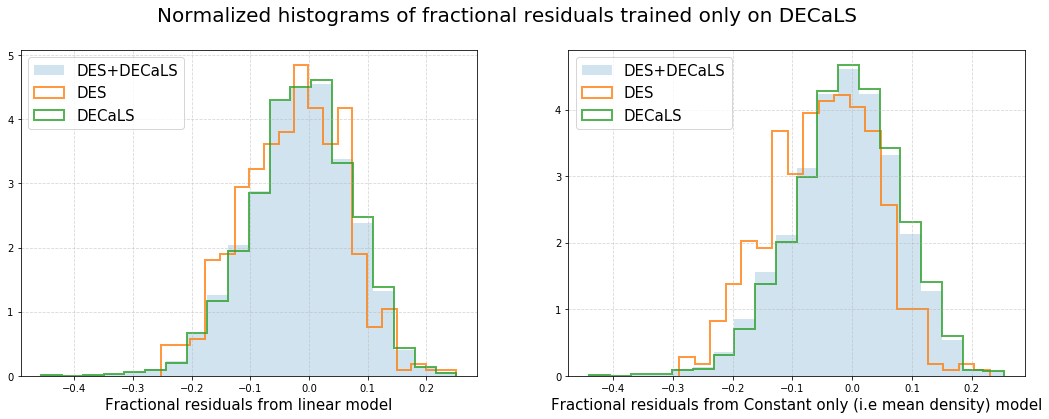

In [7]:
fig, ax = plt.subplots(1,2, figsize=(18,6))

ax[0].hist(data_32["frac_lin_res"], bins = 20, label="DES+DECaLS", alpha =0.2, density=True)
ax[0].hist(data_32_des["frac_lin_res"], bins=20, alpha=0.8, label="DES", histtype = "step", lw =2,density=True)
ax[0].hist(data_32_decals["frac_lin_res"], bins=20, alpha=0.8, label="DECaLS",  histtype = "step", lw=2,density=True)
ax[0].grid(alpha=0.5, ls ="--")
ax[0].legend(loc=0, prop={'size': 15})
ax[0].set_xlabel("Fractional residuals from linear model", size=15)

ax[1].hist(data_32["frac_cons_res"], bins = 20, label="DES+DECaLS", alpha =0.2, density=True)
ax[1].hist(data_32_des["frac_cons_res"], bins=20, alpha=0.8, label="DES", histtype = "step", lw =2,density=True)
ax[1].hist(data_32_decals["frac_cons_res"], bins=20, alpha=0.8, label="DECaLS",  histtype = "step", lw=2,density=True)
ax[1].grid(alpha=0.5, ls ="--")
ax[1].legend(loc=0, prop={'size': 15})
ax[1].set_xlabel("Fractional residuals from Constant only (i.e mean density) model",size=15)

fig.suptitle("Normalized histograms of fractional residuals trained only on DECaLS", size=20)

**Summary:** If we train the LASSO model only on the `DECaLS` region, and evaluate mean residuals from that model for `DES` and `DECaLS` separately, there is a less than 3% offset in the predicted densities on average.  
So, if we assume the trends are the same in `DES` and `DECaLS` based on what we know from DECaLS we would be able to predict the observed offsets in density. We see that the `DES-DECaLS` mean density offset is consistent with zero. (The calculations of the statistics for the above samples are presented at the end of this notebook.)

### Residuals from each predictor after model was trained on DECaLS but tested on DES

Below we plot the residuals for each predictor separately. We first determine the total residual for the model as $\text{Total Residual = observed density - predicted density}$. Now the residual for each predictor is calculated as: $\text{Total residual}+C_i\times x_i$ where $C_i$ is the slope corresponding to each predictor in the linear model and $x_i$ represents the values for each predictor. We are essentially adding back the contribution of each predictor one by one to the total residual. The straight lines denote the component of the linear model fittedt to `DECaLS` while the points show binned residual for the `DES` region. The error bars are the maximum of the standard error or the poisson error in each bin. All the residuals are converted to fractions by dividing them by the average density in the `DES` region.

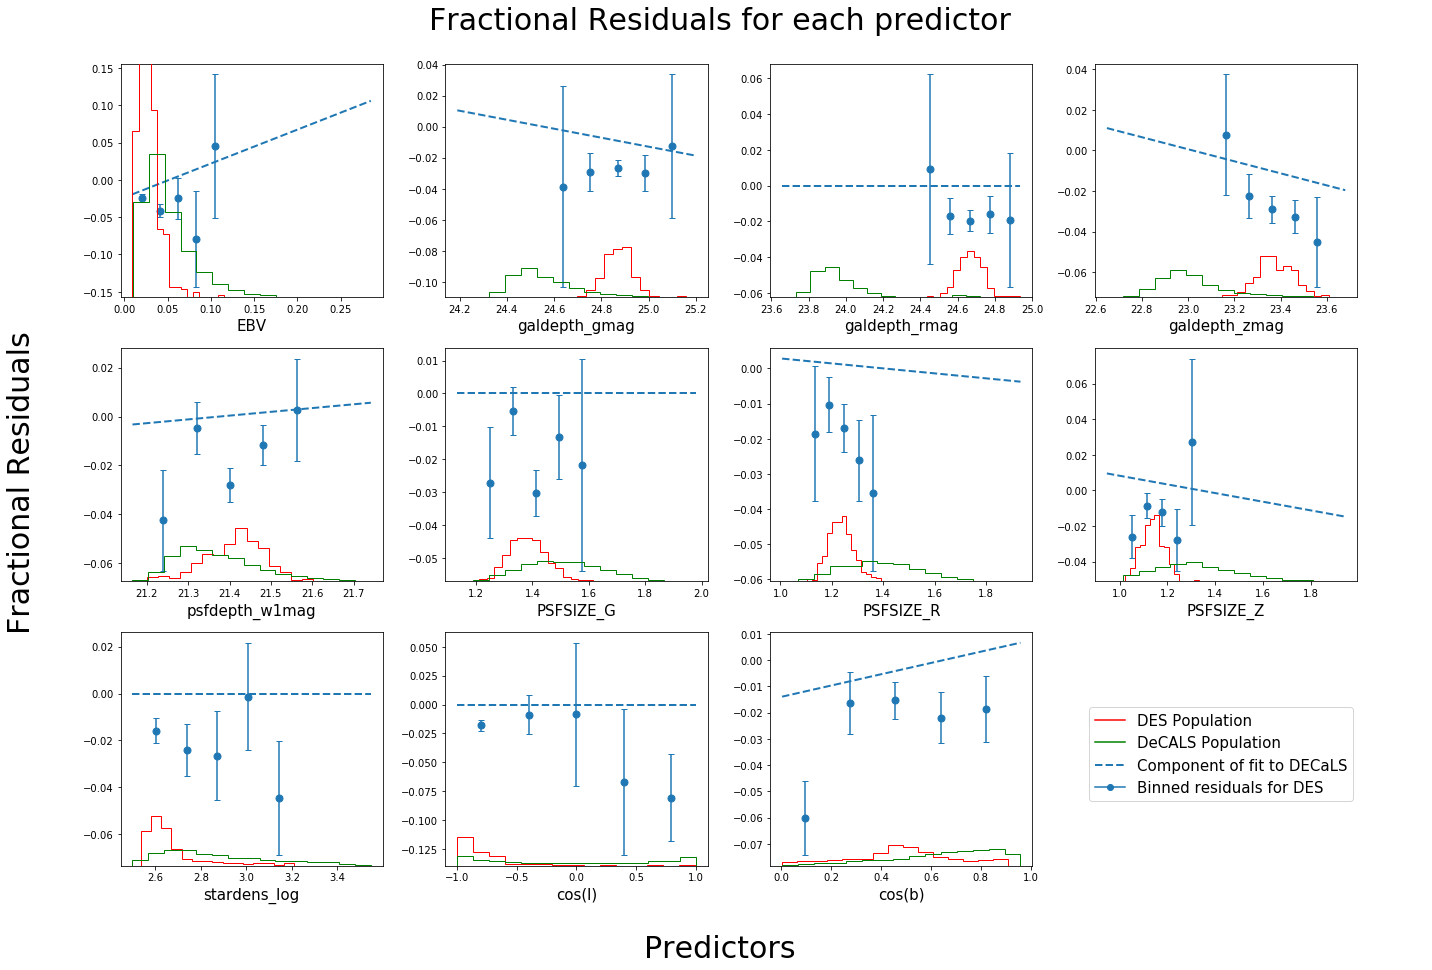

In [8]:
fig, axs = plt.subplots(3,4, figsize = (18,12))
fig.delaxes(axs[2][3])

axs = axs.flatten()
axs_twin = [ax.twinx() for ax in axs]
fig.delaxes(axs_twin[-1])

scaled_32_des = scaler.transform(data_32_des[columns])

array_des = np.array(data_32_des[columns])
array_decals = np.array(data_32_decals[columns])
array_data = np.array(data_32[columns])

avg_density = np.mean(data_32_des["density"])

num_bins =5

for i, ax in enumerate(axs[:-1]):
    
    residual = (data_32_des["lin_res"] +  scaled_32_des[:,i]*lasso_sgd.coef_[i])

    
    #Bin the data
    bin_res, bin_edges, bin_num = binned_statistic(array_des[:,i], residual, statistic = "mean", bins=num_bins)
    
    frac_mean = bin_res/avg_density
    
    std, bin_edges,_ = binned_statistic(array_des[:,i], residual, statistic = "std", bins=num_bins)
    std = std/avg_density
    
    
    # Standard error: Standard deviation of each bin divided by sqrt(population)
    pop, _ = np.histogram(array_des[:,i], bins=num_bins)
    #Should be in terms of densities
    std_err = std/np.sqrt(pop)
    
    #Poisson error
    pois_err = np.zeros(num_bins)
    for b in range(num_bins):
        mask = (bin_num==b+1)
        data_bin = data_32_des[mask].copy()
        pop_bin = data_bin["pix_pop"].sum()
        area_bin = data_bin["pix_area"].sum()
        pois_err[b] = np.sqrt(pop_bin)/area_bin
    pois_err = pois_err/avg_density
    
    #Error is maximum of the standard error or the poisson error
    error = np.maximum(std_err, pois_err)
    
    x_bin = (bin_edges[1:]+bin_edges[:-1])/2
    
    x_line = np.linspace(array_data[:,i].min(), array_data[:,i].max(), 10)
    # rescale x
    x_line_scaled = np.zeros((10, len(columns)))
    x_line_scaled[:,i] = x_line
    x_line_scaled = scaler.transform(x_line_scaled)
    
    hist_des, des_bin_edges = np.histogram(array_des[:,i], bins=15, density=True)
    hist_decals, decals_bin_edges = np.histogram(array_decals[:,i], bins=15, density=True)
    
    des_centers = 0.5*(des_bin_edges[1:]+des_bin_edges[-1:])
    decals_centers = 0.5*(decals_bin_edges[1:]+decals_bin_edges[-1:])
    
    
    normalize = 30
    

    axs_twin[i].hist(des_bin_edges[:-1], bins=des_bin_edges, weights=hist_des/normalize, label="des", lw=1, histtype="step", color="r")
    axs_twin[i].hist(decals_bin_edges[:-1], bins=decals_bin_edges, weights=hist_decals/normalize,  label="decals",   lw=1, histtype="step", color="g")

    axs_twin[i].set_ylim(0,1)
    axs_twin[i].axis("off")
    
    
    ax.errorbar(x_bin, frac_mean, yerr = error, fmt="o", ms=7, lw=1.5, capsize=3)
    #CHANGE THIS
    ax.plot(x_line, (lasso_sgd.coef_[i]*x_line_scaled[:,i])/avg_density, c= "C0", ls ="--", lw=2)
    ax.set_xlabel(columns[i], size=15)

handle1 = lines.Line2D([], [], c='r')
handle2 = lines.Line2D([], [], c='g')
handle3 = lines.Line2D([], [], c='C0', ls ="--", lw=2)
handle4 = lines.Line2D([], [], c='C0', marker="o")

fig.legend( (handle1,handle2,handle3, handle4), ("DES Population", "DeCALS Population", "Component of fit to DECaLS", "Binned residuals for DES"), loc="center right", bbox_to_anchor=(1.05,0.25), prop={'size': 15}, ncol=1)

fig.text(0.5, -0.05, r"Predictors", ha='center',size=30) #Common x label
fig.text(-0.05, 0.5, "Fractional Residuals", va='center', rotation='vertical',size=30) #Common y label
fig.suptitle("Fractional Residuals for each predictor", size=30, y=1.05)
plt.tight_layout()

**Summary:** We see that the linear model fitted to `DECaLS` tends to describe the offsets to `DES` pretty well. This also shows that selection is quite uniform accros the two regions.

### Plot Healpix maps of the residulas of DES and DECaLS region

**Fractional residuals from Linear Model**

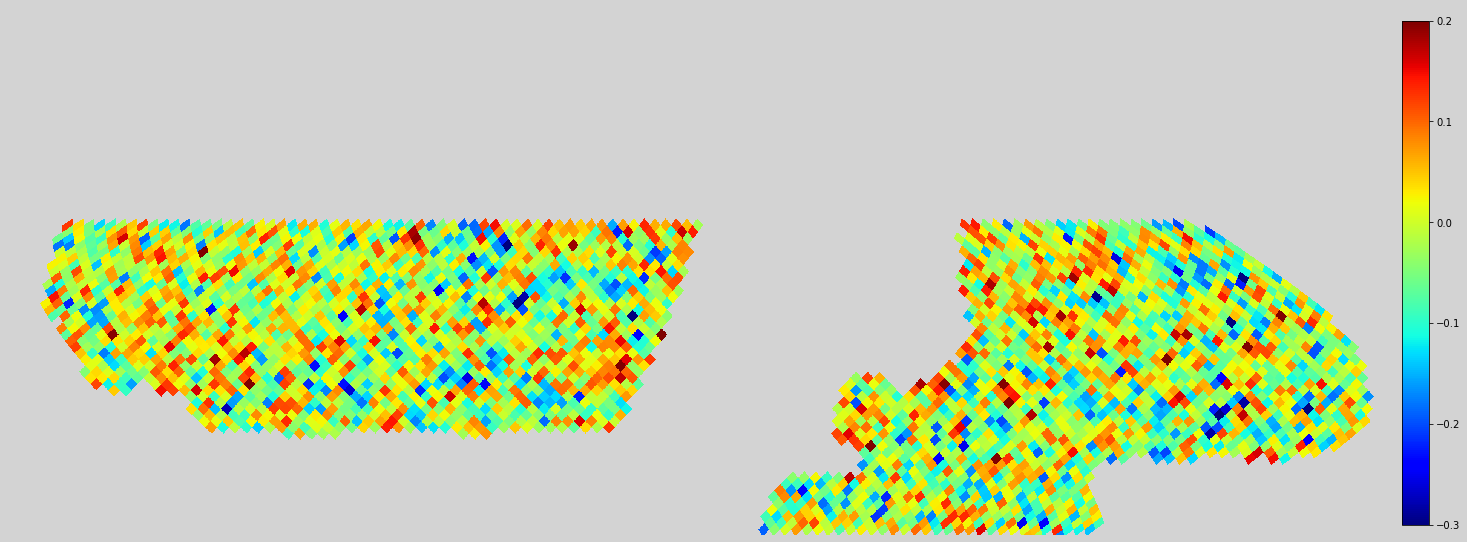

In [9]:
hp_map = plot_hpix(data_32, 32, "frac_lin_res", region="bm")

**Fractional Residuals from constant only model**

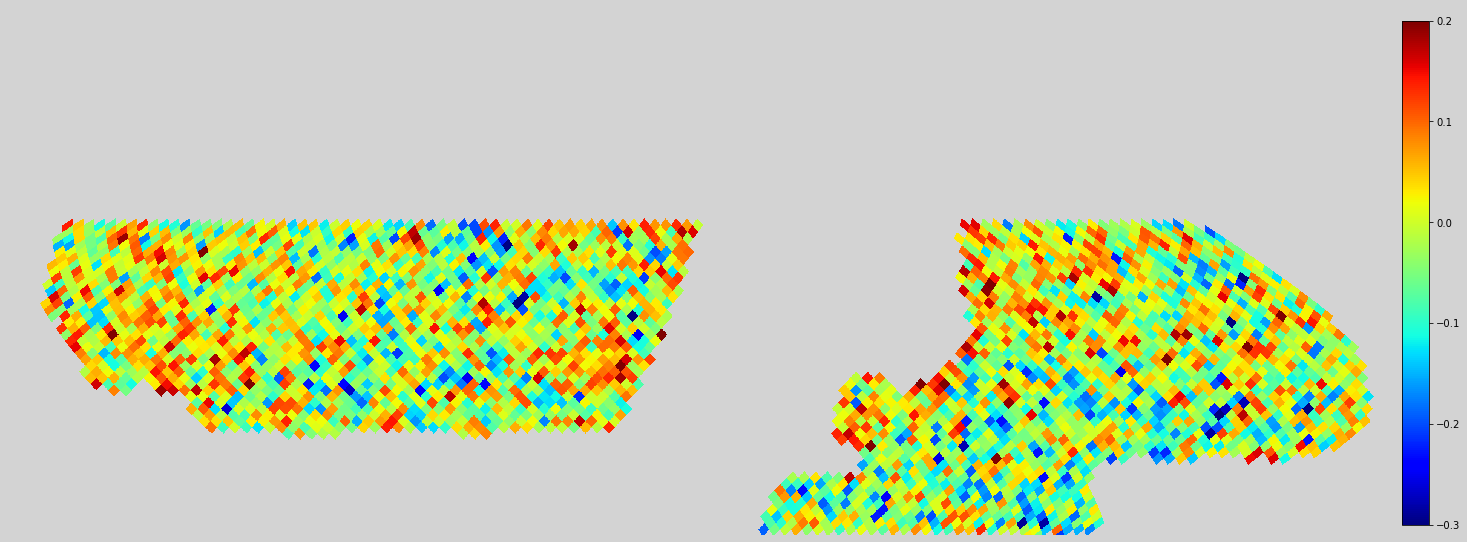

In [10]:
hp_map = plot_hpix(data_32, 32, "frac_cons_res", region="bm")

**Summary:** From the maps we see that the offsets in the predicted densities stay roughly the same over the `DECaLS` and `DES` regions. The linear model tends to predict higher densities for the `DES` region than the `DECaLS` region which is also evident from the histograms above and the statistics shown below.

### Print statistics for the fractional residuals

**Linear Model**

In [11]:
print("DES+Decals:")
print("Mean:", data_32["lin_res"].sum()/data_32["density"].sum())
print("Median:", np.median(data_32["frac_lin_res"]))
print("IQR:", iqr(data_32["frac_lin_res"]))
print()
print("DES:")
print("Mean:", data_32_des["lin_res"].sum()/data_32_des["density"].sum())
print("Median:", np.median(data_32_des["frac_lin_res"]))
print("IQR:", iqr(data_32_des["frac_lin_res"]))
print()
print("DECaLS:")
print("Mean:", data_32_decals["lin_res"].sum()/data_32_decals["density"].sum())
print("Median:", np.median(data_32_decals["frac_lin_res"]))
print("IQR:", iqr(data_32_decals["frac_lin_res"]))

DES+Decals:
Mean: -0.007082192643282862
Median: -0.011046037607607933
IQR: 0.1138184585624566

DES:
Mean: -0.018201119677912905
Median: -0.018953308248871807
IQR: 0.12320734276839326

DECaLS:
Mean: -0.005520236104261895
Median: -0.009855932199478841
IQR: 0.11353636143217713


**Constant Only (i.e. Mean density) Model**

In [12]:
print("DES+Decals:")
print("Mean:", data_32["cons_res"].sum()/data_32["density"].sum())
print("Median:", np.median(data_32["frac_cons_res"]))
print("IQR:", iqr(data_32["frac_cons_res"]))
print()
print("DES:")
print("Mean:", data_32_des["cons_res"].sum()/data_32_des["density"].sum())
print("Median:", np.median(data_32_des["frac_cons_res"]))
print("IQR:", iqr(data_32_des["frac_cons_res"]))
print()
print("DECaLS:")
print("Mean:", data_32_decals["cons_res"].sum()/data_32_decals["density"].sum())
print("Median:", np.median(data_32_decals["frac_cons_res"]))
print("IQR:", iqr(data_32_decals["frac_cons_res"]))

DES+Decals:
Mean: -0.004925628594419834
Median: -0.008374205256862511
IQR: 0.11695558602484209

DES:
Mean: -0.03998915537817571
Median: -0.042508110218565695
IQR: 0.1290894737899568

DECaLS:
Mean: -1.5447801241766872e-15
Median: -0.003304297332669756
IQR: 0.11492678442572278
